In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt    
%matplotlib inline
from matplotlib import rcParams
import matplotlib.image as mpimg
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16
rcParams['figure.figsize'] = 10.25, 6
from PIL import Image
from images2gif import writeGif

In [18]:
zmb = pd.read_csv("..\\zombieprofiles.csv", encoding="utf-8")
zmb["sigma"]=1/(zmb["Incubation Seconds"]/(24*60*(60*.100000000000)))
zmb["beta"]= [1.5, 2, 4, 6, 6.5]
zmb["gamma"]= [.5/1.5, .5/2, .5/4,.5/6, .5/6.5]
zmb

,Unnamed: 0,Work of Origin,Speed,Incubation Time,Incubation Seconds,Speed Rank,sigma,beta,gamma
0,0,Living Dead Trilogy,Slow,2-36 hours,7200,1,1.2,1.5,0.333333
1,1,World War Z (film),Fast,10-12 seconds,10,5,864.0,2.0,0.250000
2,2,Zombieland,Fast,4 hours - 5 minutes,300,3,28.8,4.0,0.125000
3,3,28 Days Later,Fast,Under a minute,30,4,288.0,6.0,0.083333
4,4,The Walking Dead,Slow*,3 minutes-8 hours,180,2,48.0,6.5,0.076923


In [19]:
pl = pd.DataFrame(columns=["Name","LnLt"])
pl["Name"]=["Dallas","Los_Angeles","Atlanta","Chicago","New_York"]
pl["LnLt"]=[(-96.797,32.7767),(-118.2437,34.0522),(-84.3880, 33.7490),(-87.6298, 41.8781),(-74.0060,40.7128)]
pl["N"]=[1345047, 3990456,498044,2705994,8398748]
pl["rng"]=[(290,353),(270, 85),(278,505),(150,464),(167,635)]
pl["lmt"]=[1500, 4000,600,3000,8500]
pl.reset_index()
pl

,Name,LnLt,N,rng,lmt
0,Dallas,"(-96.797, 32.7767)",1345047,"(290, 353)",1500
1,Los_Angeles,"(-118.2437, 34.0522)",3990456,"(270, 85)",4000
2,Atlanta,"(-84.388, 33.749)",498044,"(278, 505)",600
3,Chicago,"(-87.6298, 41.8781)",2705994,"(150, 464)",3000
4,New_York,"(-74.006, 40.7128)",8398748,"(167, 635)",8500


In [20]:
opt=zmb.assign(foo=1).merge(pl.assign(foo=1)).drop('foo', 1)
opt.head()

,Unnamed: 0,Work of Origin,Speed,Incubation Time,Incubation Seconds,Speed Rank,sigma,beta,gamma,Name,LnLt,N,rng,lmt
0,0,Living Dead Trilogy,Slow,2-36 hours,7200,1,1.2,1.5,0.333333,Dallas,"(-96.797, 32.7767)",1345047,"(290, 353)",1500
1,0,Living Dead Trilogy,Slow,2-36 hours,7200,1,1.2,1.5,0.333333,Los_Angeles,"(-118.2437, 34.0522)",3990456,"(270, 85)",4000
2,0,Living Dead Trilogy,Slow,2-36 hours,7200,1,1.2,1.5,0.333333,Atlanta,"(-84.388, 33.749)",498044,"(278, 505)",600
3,0,Living Dead Trilogy,Slow,2-36 hours,7200,1,1.2,1.5,0.333333,Chicago,"(-87.6298, 41.8781)",2705994,"(150, 464)",3000
4,0,Living Dead Trilogy,Slow,2-36 hours,7200,1,1.2,1.5,0.333333,New_York,"(-74.006, 40.7128)",8398748,"(167, 635)",8500


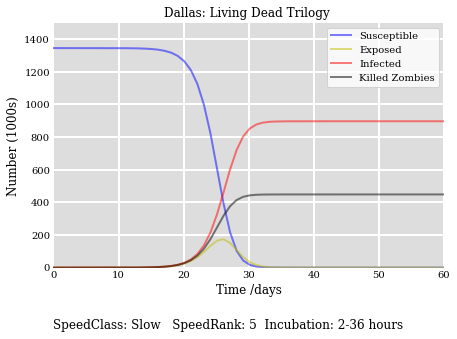

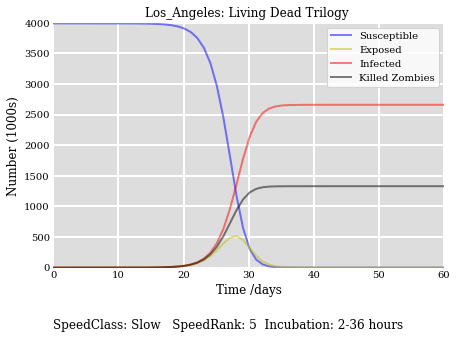

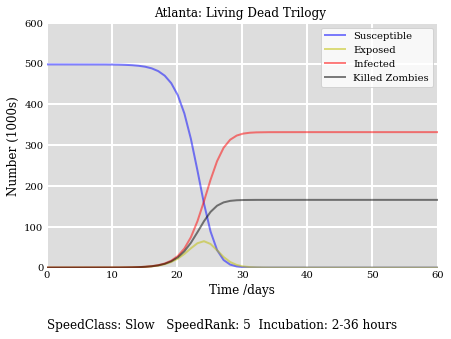

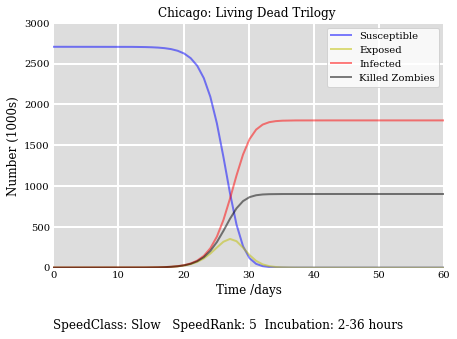

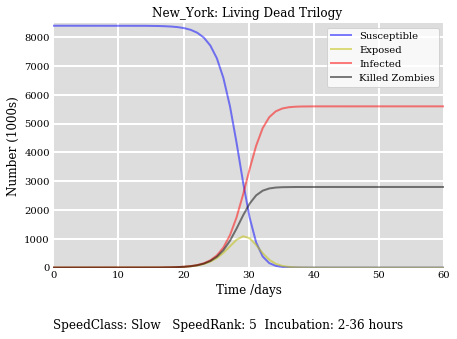

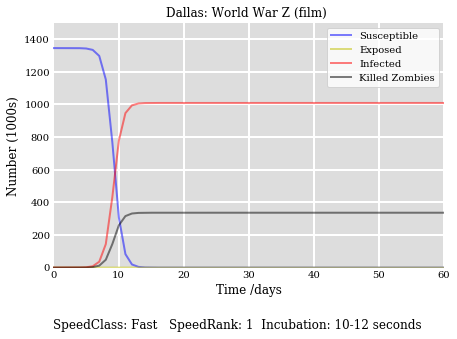

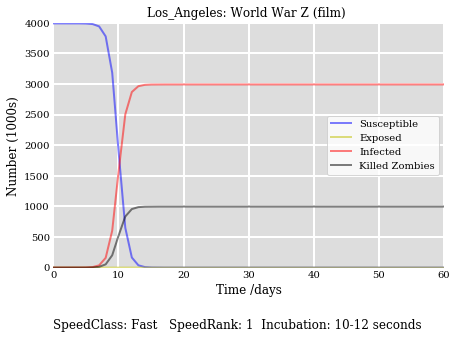

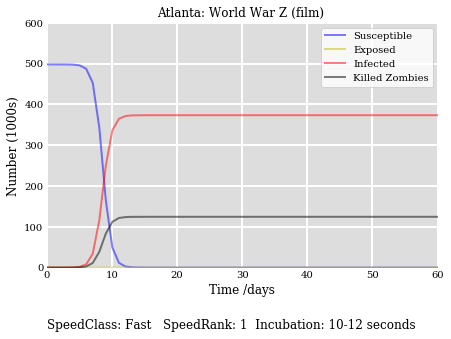

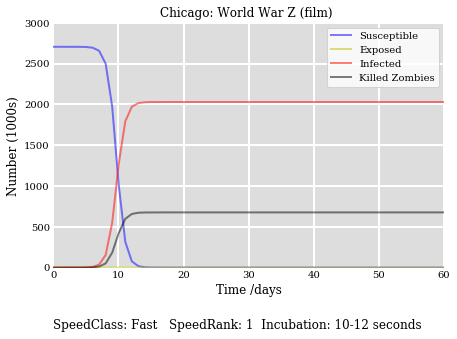

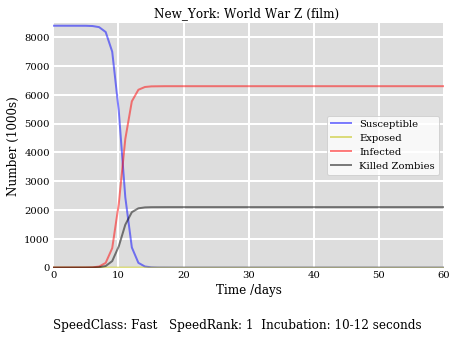

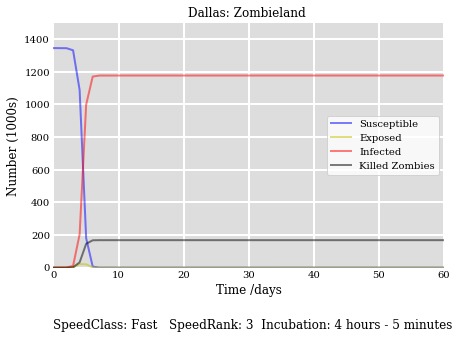

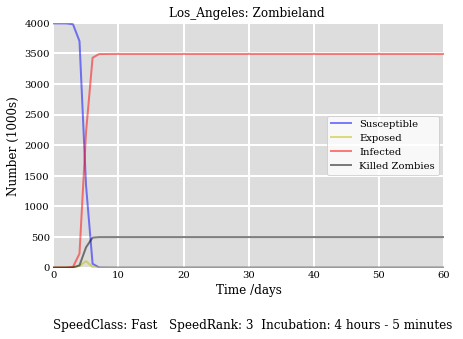

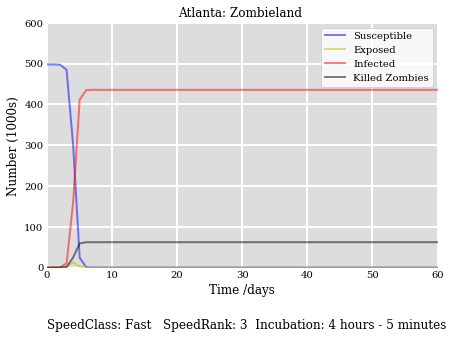

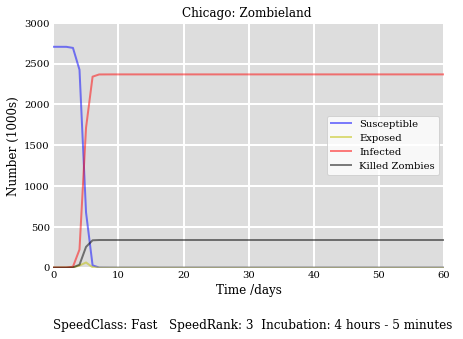

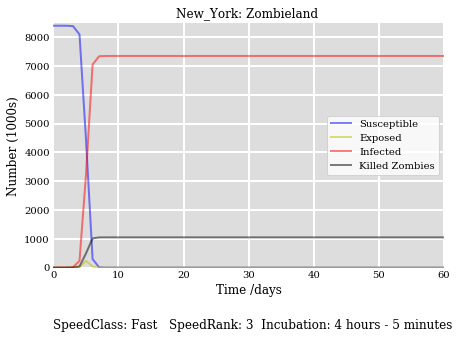

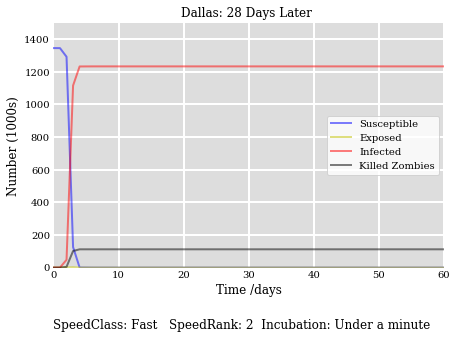

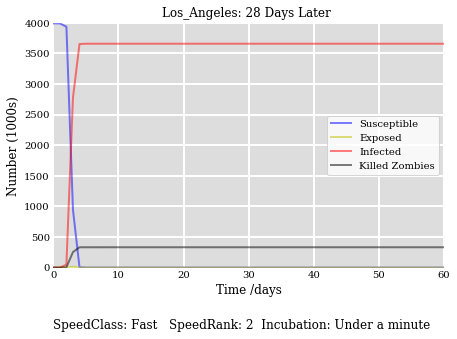

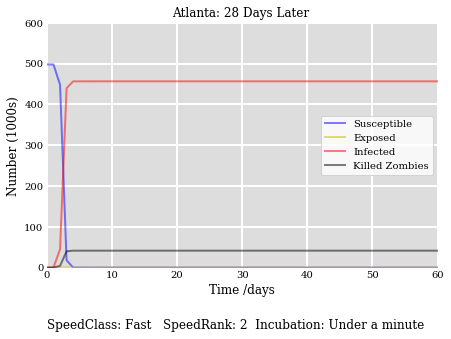

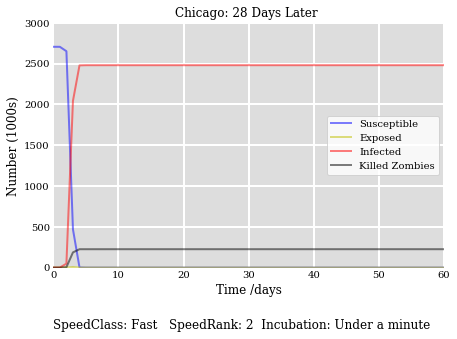

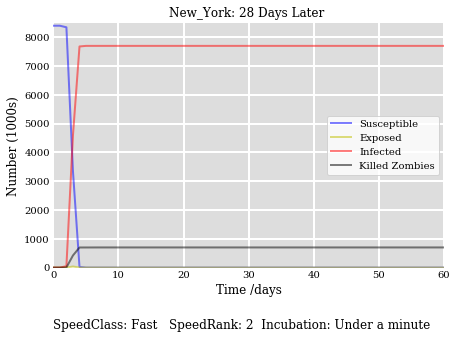

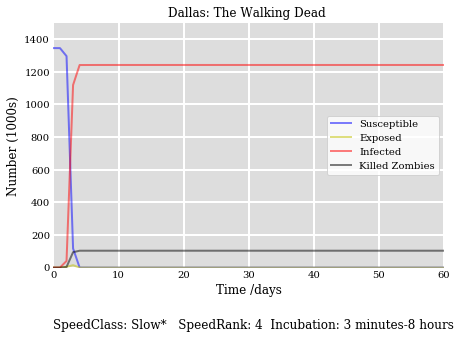

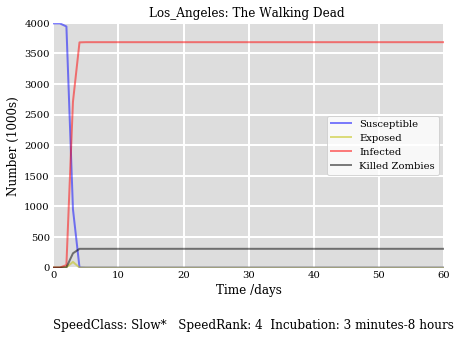

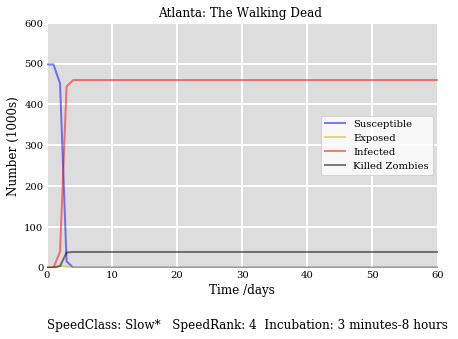

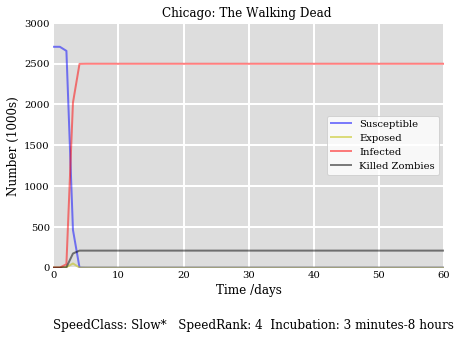

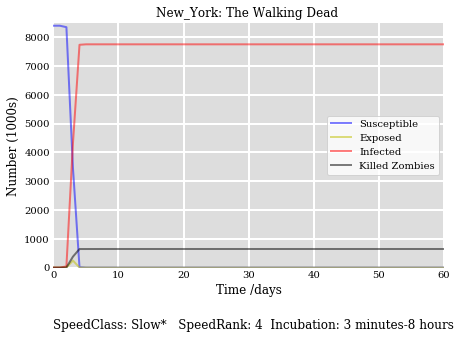

In [22]:
import os, shutil
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from matplotlib.widgets import TextBox


for i, row in opt.iterrows():
    lmt=opt['lmt'][i]
    speed=opt['Speed'][i]
    sigma=opt['sigma'][i]
    beta=opt['beta'][i]
    gamma=opt['gamma'][i]
    citypop=opt['N'][i]
    incubation=opt['Incubation Time'][i]
    profile=opt['Work of Origin'][i]
    speedrank=opt['Speed Rank'][i]
    rng = (opt['rng'][i])
    city=opt['Name'][i]

    # Total population, N.
    N = citypop
    # Initial number of infected and recovered individuals, I0 and R0.
    E0, I0, R0 = 0, 1, 0
    # Everyone else, S0, is susceptible to infection initially.
    S0 = N - I0 - R0
    # Contact rate, beta, and mean recovery rate, gamma, (in 1/days).

    # A grid of time points (in days)
    t = np.linspace(0, 200, 200)

    # The SIR model differential equations.
    def deriv(y, t, N, beta, gamma, sigma):
        S,E, I, R = y
        dSdt = -beta * S * I / N
        dEdt= beta * S * I / N - sigma * E
        dIdt = sigma * E - gamma* (beta * S * I / N)
        dRdt =  gamma * (beta * S * I / N)
        return dSdt,dEdt, dIdt, dRdt

    # Initial conditions vector
    y0 = S0, E0, I0, R0
    # Integrate the SIR equations over the time grid, t.
    ret = odeint(deriv, y0, t, args=(N, beta, gamma, sigma))
    S, E, I, R = ret.T

    # Plot the data on three separate curves for S(t), I(t) and R(t)
    fig = plt.figure(facecolor='w',frameon=True, figsize = [7, 5])



    ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
    ax.plot(t, S/1000, 'b', alpha=0.5, lw=2, label='Susceptible')
    ax.plot(t, E/1000, 'y', alpha=0.5, lw=2, label='Exposed')
    ax.plot(t, I/1000, 'r', alpha=0.5, lw=2, label='Infected')
    ax.plot(t, R/1000, 'black', alpha=0.5, lw=2, label='Killed Zombies')
    ax.set_xlabel('Time /days',  fontsize=12)
    ax.set_ylabel('Number (1000s)',  fontsize=12)
    ax.set_ylim(0,lmt)
    ax.set_xlim(0,60)
    plt.title(city + ": "+profile)
    ax.yaxis.set_tick_params(length=0)
    ax.xaxis.set_tick_params(length=0)

    ax.text(0, -lmt/4, "SpeedClass: "+ speed +"  SpeedRank: "+str(6-speedrank) +"  Incubation: "+incubation,  fontsize=12)

    ax.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax.legend()

    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)

    fig.subplots_adjust(bottom=0.2)

    plt.savefig("C:\\Users\\silva\\Documents\\GitHub\\FinalProject\\FinalProject\\Data\\Plots\\"+\
               city+""+ str(speedrank).zfill(2)+".png")    
    
    
    

    